In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

import numpy as np
import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from functionMaths import *

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp', host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33591 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:33591/status,
Dashboard: http://137.129.155.67:33591/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:38873,Workers: 1
Dashboard: http://137.129.155.67:33591/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:33469,Total threads: 4
Dashboard: http://137.129.155.67:32875/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = ['OLR_Kelvin']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
coeff = 1


In [6]:
ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 32*6}, parallel = True)
_ds = ds.isel(time = slice(0,None,32*2))
_ds = _ds.sel(lat = slice(-30,30))

# ### Compute temporal derivative
# ds_DDt = ds.differentiate('time', datetime_unit = "s")
# _ds_DDt = ds_DDt.sel(lat = slice(-30,30))

# ds_std = _ds.std(dim = ['time'])
# ds_DDt_std = _ds_DDt.std(dim = ['time'])

# # Normalizing by standard deviation
# ds_norm = _ds/ds_std
# _ds_DDt = _ds_DDt/ds_DDt_std

# ### Stock in one datasets
# for w in wave_OLR :
#     ds_norm[w + '_DT'] = _ds_DDt[w]

In [3]:
    
### Compute variance of the data
v1 = ds_norm['OLR_Kelvin']
v2 = ds_norm['OLR_Kelvin_DT']

ds_plot = amplitudeMagnitude(v1, v2)

space_phase = np.linspace(np.pi, -np.pi, 33, endpoint = True)
d_space_phase = (space_phase[1] - space_phase[2])/2
space_phase = space_phase[:-1] - d_space_phase

nb_phase = np.linspace(0, 31, 32, dtype = 'int')
ds_plot = ds_plot.expand_dims(phase = nb_phase, axis = 3)
ds_plot

,Array,Chunk
Bytes,4.23 GiB,15.82 MiB
Shape,"(822, 60, 360, 32)","(3, 60, 360, 32)"
Count,5645 Tasks,282 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,4.23 GiB,15.82 MiB
Shape,"(822, 60, 360, 32)","(3, 60, 360, 32)"
Count,6491 Tasks,282 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [4]:
ds_plot['amplitude'] = ds_plot['amplitude'].load()
ds_plot

,Array,Chunk
Bytes,4.23 GiB,15.82 MiB
Shape,"(822, 60, 360, 32)","(3, 60, 360, 32)"
Count,6491 Tasks,282 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,4.23 GiB,15.82 MiB
Shape,"(822, 60, 360, 32)","(3, 60, 360, 32)"
Count,7337 Tasks,282 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [ ]:
ampl = np.arctan2(v2,v1) ### arctan2 variable on y first, on x second
magn = np.sqrt(v1**2 + v2**2)

ampl = ampl.rename('ampl')
magn = magn.rename('magn')

In [13]:
# for i in range(nb_phase.size-1) :
#     da = xr.where( ((ampl <=  space_phase[i]) & ( ampl > space_phase[i+1]) == True),
#                                        ampl, np.nan)
#     ds_plot['amplitude'][...,i+1] = da
#     del da

for i in range(nb_phase.size-1) :
    print(i)
    da = xr.where( ((ds_plot['amplitude'][...,i+1] <=  space_phase[i]) & ( ds_plot['amplitude'][...,i+1] > space_phase[i+1]) == True),
                                       ds_plot['amplitude'][...,i+1], np.nan)
    ds_plot['amplitude'][...,i+1] = da
    del da
    
da = xr.where( ((ds_plot['amplitude'][...,0] <=  space_phase[-1]) | ( ds_plot['amplitude'][...,0] > space_phase[0]) == True),
                                       ds_plot['amplitude'][...,0], np.nan)
ds_plot['amplitude'][...,0] = da 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [9]:
ds_plot['magnitude'] = ds_plot['magnitude'].load()


In [17]:
# ds_plot['magnitude'] = ds_plot['magnitude'].expand_dims(phase = __ds['phase'], axis = 2)
ds_plot['magnitude'] = xr.where(ds_plot['amplitude'].isnull() != True, ds_plot['magnitude'], np.nan)

ds_plot['vect_x'] = ds_plot['magnitude'] * np.cos(ds_plot['amplitude'])
ds_plot['vect_y'] = ds_plot['magnitude'] * np.sin(ds_plot['amplitude'])


In [14]:
ds_plot['amplitude']

<xarray.DataArray 'amplitude' (time: 822, lat: 60, lon: 360, phase: 32)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,  2.8239298 , ...,         nan,
                  nan,         nan],
         [        nan,         nan,  2.66236975, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,  2.79295213, ...,         nan,
                  nan,         nan],
         [        nan,         nan,  2.68800382, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,  2.66677077, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * phase    (phase) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2018-12-26
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [18]:
ds_plot.to_netcdf('/cnrm/tropics/commun/DATACOMMUN/WAVE/SCRIPTS/ANALYSIS/PHASE/Kelvin.nc')

In [4]:
ds_plot = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/PHASE/Kelvin.nc', chunks = {'time':1})
ds_plot

,Array,Chunk
Bytes,4.23 GiB,5.27 MiB
Shape,"(822, 60, 360, 32)","(1, 60, 360, 32)"
Count,823 Tasks,822 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,4.23 GiB,5.27 MiB
Shape,"(822, 60, 360, 32)","(1, 60, 360, 32)"
Count,823 Tasks,822 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


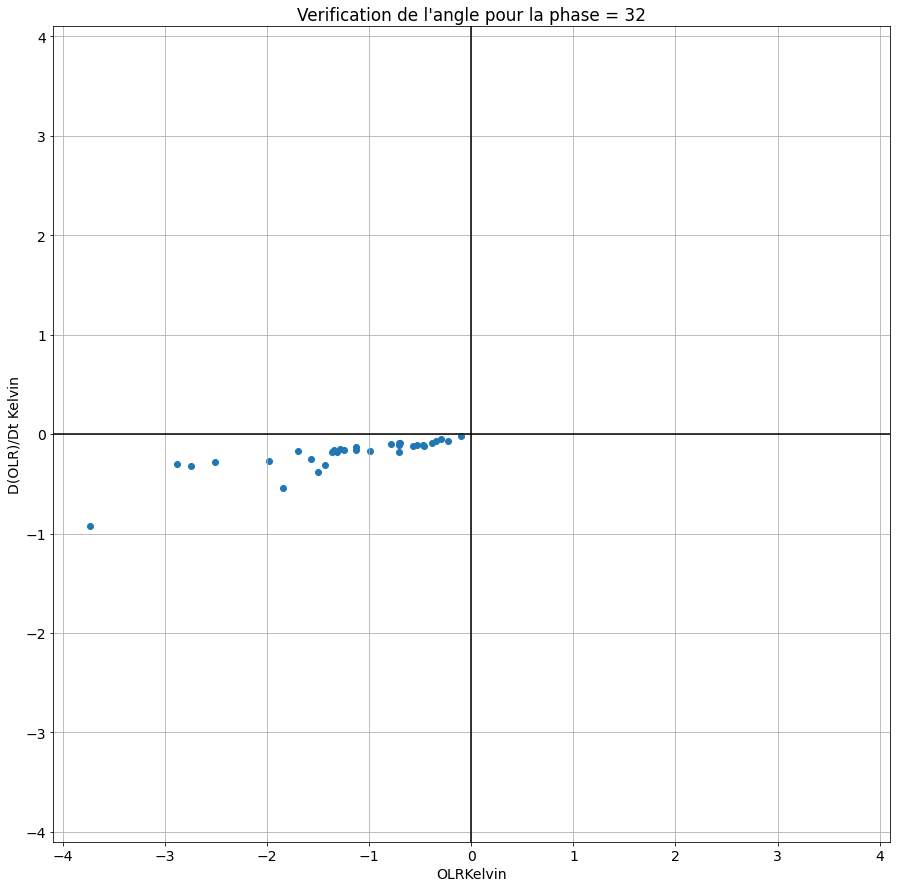

In [5]:
_wave = 'Kelvin'
fig, axes = plt.subplots(figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
# ds_norm.sel(lon = 140.5).plot.scatter(x = 'OLR_Kelvin', y = 'OLR_' + _wave + '_DT')
ds_plot.sel( phase = 31, lat=0.5, lon = 140.5).plot.scatter(x = 'vect_x', y = 'vect_y')
axes.set_ylabel('D(OLR)/Dt ' + _wave)
axes.set_xlabel('OLR' + _wave)
axes.hlines(0, -250, 100, colors = 'black')
axes.vlines(0, -55, 55, colors = 'black')
axes.set_title('Verification de l\'angle pour la phase = 32')
axes.set_xlim(-4.1,4.1)
axes.set_ylim(-4.1,4.1)
axes.grid()

In [ ]:
_wave = 'Kelvin'
fig, axes = plt.subplots(figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds_norm.plot.scatter(x = 'OLR_Kelvin', y = 'OLR_' + _wave + '_DT')
__ds.sel( phase = 0).plot.scatter(x = 'vect_x', y = 'vect_y')
axes.set_ylabel('D(OLR)/Dt ' + _wave)
axes.set_xlabel('OLR' + _wave)
axes.hlines(0, -250, 100, colors = 'black')
axes.vlines(0, -55, 55, colors = 'black')
axes.set_title('Verification de l\'angle pour la phase = 1')
axes.set_xlim(-4.1,4.1)
axes.set_ylim(-4.1,4.1)
axes.grid()

<xarray.Dataset>
Dimensions:    (time: 822, lon: 360)
Coordinates:
    phase      int64 0
  * time       (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2018-12-26
    lat        float32 0.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    amplitude  (time, lon) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    magnitude  (time, lon) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    vect_x     (time, lon) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>
    vect_y     (time, lon) float64 dask.array<chunksize=(1, 360), meta=np.ndarray>

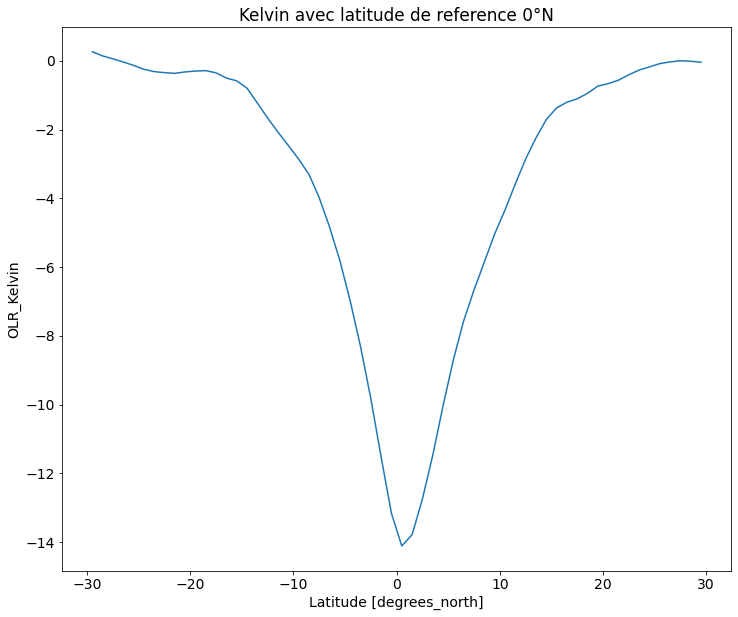

In [9]:
_ds_Test = ds_plot.sel(lat = 0, phase = 0, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
_ds_Test

da = _ds['OLR_Kelvin'].load()
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)

da = da.where(_ds_Test['amplitude'].isnull() != True)
da_m = da.mean(dim = ['time','lon'])
da_m.plot()
plt.title('Kelvin avec latitude de reference 0°N')
plt.savefig('/cnrm/tropics/commun/DATACOMMUN/WAVE/FIGURES/NAKAMURA/Kelvin_LAT_REF_0_PHASE_MIN.png')

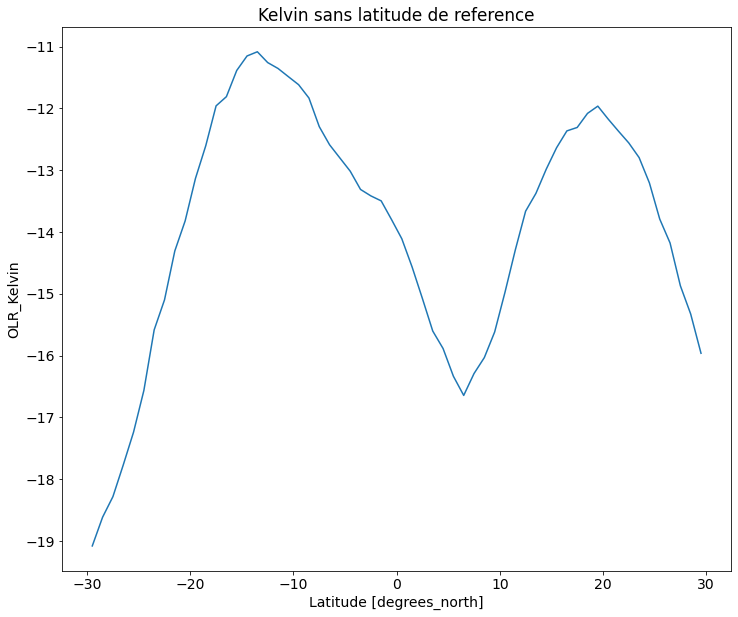

In [10]:
da = ds['OLR_Kelvin']
_ds_Test = ds_plot.sel(phase = 0, method = 'nearest')
da_p = da.where(_ds_Test['amplitude'].isnull() != True)
da_m = da_p.mean(dim = ['time','lon']).load()
plt.figure()
da_m.plot()
# plt.title('lat 15')
plt.title('Kelvin sans latitude de reference')
plt.savefig('/cnrm/tropics/commun/DATACOMMUN/WAVE/FIGURES/NAKAMURA/Kelvin_LAT_NOREF_PHASE_MIN.png')
plt.show()


In [28]:
_ds_Test = ds_plot['amplitude'].sel(lat = 0, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
_ds_Test

,Array,Chunk
Bytes,4.23 GiB,5.27 MiB
Shape,"(822, 60, 360, 32)","(1, 60, 360, 32)"
Count,3289 Tasks,822 Chunks
Type,float64,numpy.ndarray


In [29]:
_ds_3 = da.expand_dims(phase = _ds_Test['phase'], axis = 3)
_ds_3 = da.where(_ds_Test.isnull() != True)
_ds_3


,Array,Chunk
Bytes,4.23 GiB,5.27 MiB
Shape,"(822, 60, 360, 32)","(1, 60, 360, 32)"
Count,13154 Tasks,822 Chunks
Type,float64,numpy.ndarray


([<matplotlib.axis.XTick at 0x7fe590cb0220>,
 [Text(-8, 0, '$-\\pi$'),
  Text(0, 0, '$-\\pi/2$'),
  Text(7, 0, '0'),
  Text(15, 0, '$\\pi/2$'),
  Text(23, 0, '$\\pi$')])

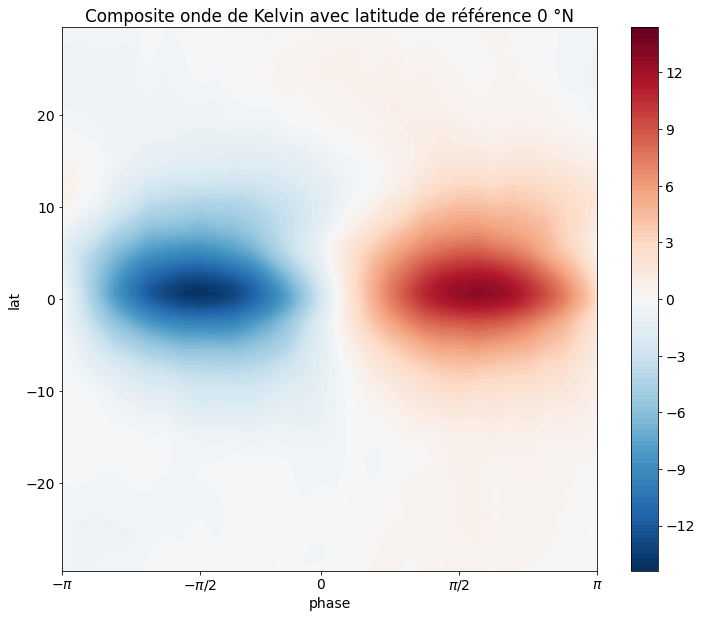

In [10]:
_ds_3 = _ds['OLR_Kelvin'].expand_dims(phase = ds_plot['phase'], axis = 3)

_ds_Test = ds_plot['amplitude'].sel(lat = 0, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = _ds['lat'], axis = 1)

_ds_3 = xr.where(_ds_Test.isnull() != True,
                         _ds_3, np.nan)
_ds_3 = _ds_3.mean(dim = ['time','lon']).compute()

ds_4 = _ds_3.assign_coords(phase = ((_ds_3.phase + 8) % 32) - 8).sortby('phase')
ds_4

positions = (-8, 0, 7, 15, 23)
labels = ("$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$" )

plt.figure()
ds_4.plot.contourf(levels = 100)
plt.title('Composite onde de Kelvin avec latitude de référence 0 °N')
plt.xticks(positions, labels)

In [ ]:
# _ds_4 = _ds_3.assign_coords(phase = (((ds.phase + 180) % 360) - 180)).sortby('phase')
((ds.phase + 180) % 360) - 180)

In [ ]:
_ds_Test = ds_plot.sel(lat = 0, phase = 0, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = ds_plot['lat'], axis = 1)
_ds_Test

da = _ds['OLR_Rossby'].load()
# _ds_2 = xr.where(_ds_Test.isnull() != True,
#                          _ds['OLR_Kelvin'].isel(phase = 0), np.nan)

da = da.where(_ds_Test['amplitude'].isnull() != True)
da_m = da.mean(dim = ['time','lon'])
da_m.plot()

([<matplotlib.axis.XTick at 0x7fe6241f5ee0>,
 [Text(-8, 0, '$-\\pi$'),
  Text(0, 0, '$-\\pi/2$'),
  Text(7, 0, '0'),
  Text(15, 0, '$\\pi/2$'),
  Text(23, 0, '$\\pi$')])

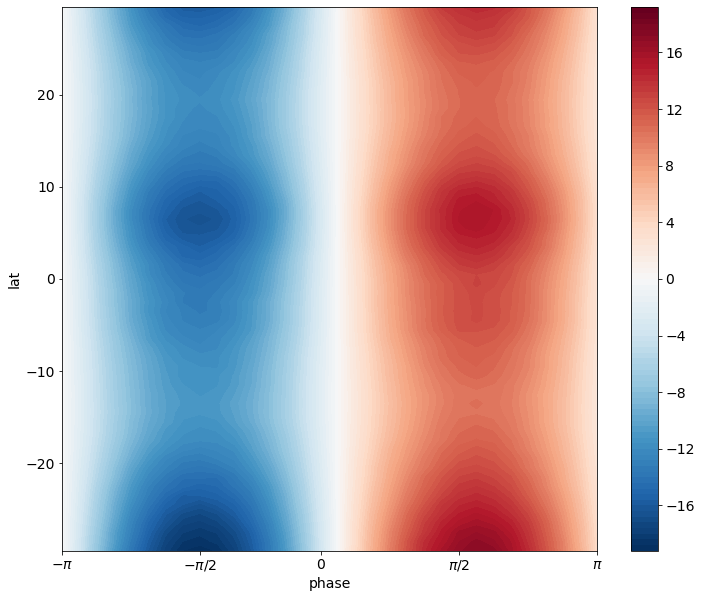

In [9]:
_ds_Test = ds_plot['amplitude']
_ds_3 = _ds['OLR_Kelvin'].expand_dims(phase = ds_plot['phase'], axis = 3)

# _ds_Test = ds_plot['amplitude'].sel(lat = 0, method = 'nearest')
# del _ds_Test['lat']
# _ds_Test = _ds_Test.expand_dims(lat = _ds['lat'], axis = 1)

_ds_3 = xr.where(_ds_Test.isnull() != True,
                         _ds_3, np.nan)
_ds_3 = _ds_3.mean(dim = ['time','lon']).compute()

ds_4 = _ds_3.assign_coords(phase = ((_ds_3.phase + 8) % 32) - 8).sortby('phase')
ds_4

positions = (-8, 0, 7, 15, 23)
labels = ("$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$" )

plt.figure()
ds_4.plot.contourf(levels = 100)
plt.title('Composite onde de Kelvin sans latitude de référence')
plt.xticks(positions, labels)